### Описание шагов находится в файле task_1.ipynb, ко второму заданию идут только код и вывод

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [58]:
def run(model, dataloader, loss_function, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_labels = []
    all_preds = []

    for X, y in dataloader:
        pred = model(X)
        loss = loss_function(pred, y)
        total_loss += loss.item()
        
        _, predicted = torch.max(pred, 1)
        correct_predictions += (predicted == y).sum().item()
        total_predictions += y.size(0)
        all_labels.extend(y.tolist())
        all_preds.extend(predicted.tolist())
        
        if optimizer is not None:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    accuracy = correct_predictions / total_predictions
    avg_loss = total_loss / len(dataloader)
    
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
    return avg_loss, accuracy, precision, recall, f1, cm

In [59]:
def show_losses(train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist):
    clear_output()

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist, label='Train Loss')
    plt.plot(np.arange(len(val_loss_hist)), val_loss_hist, label='Validation Loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(np.arange(len(train_acc_hist)), train_acc_hist, label='Train Accuracy')
    plt.plot(np.arange(len(val_acc_hist)), val_acc_hist, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.show()

In [60]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [61]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
valset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=test_transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

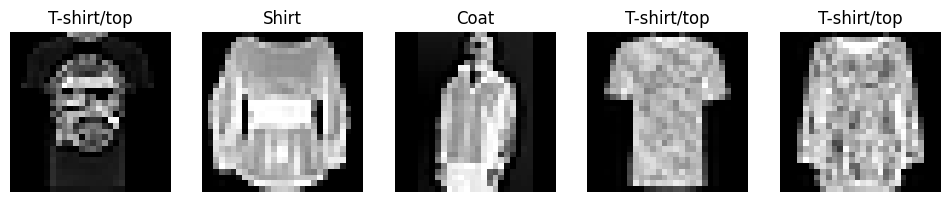

In [71]:
def show_images(dataset, num_images=5):
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))

    for i in range(num_images):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze().numpy(), cmap='gray')
        axes[i].set_title(classes[label])
        axes[i].axis('off')

    plt.show()

show_images(trainset, num_images=5)

In [62]:
val_size = int(0.1 * len(trainset))
test_size = int(0.1 * len(trainset))
train_size = len(trainset) - val_size - test_size
trainset, valset, testset = torch.utils.data.random_split(trainset, [train_size, val_size, test_size])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [63]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),  
    nn.ReLU(),
    nn.MaxPool2d(2), 

    nn.Conv2d(32, 64, kernel_size=3, padding=1), 
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Flatten(), 

    nn.Linear(64 * 7 * 7, 128),  
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(128, 64),  
    nn.ReLU(),           
    nn.Dropout(0.5),

    nn.Linear(64, 10)    
)

In [64]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [65]:
epochs = 20
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

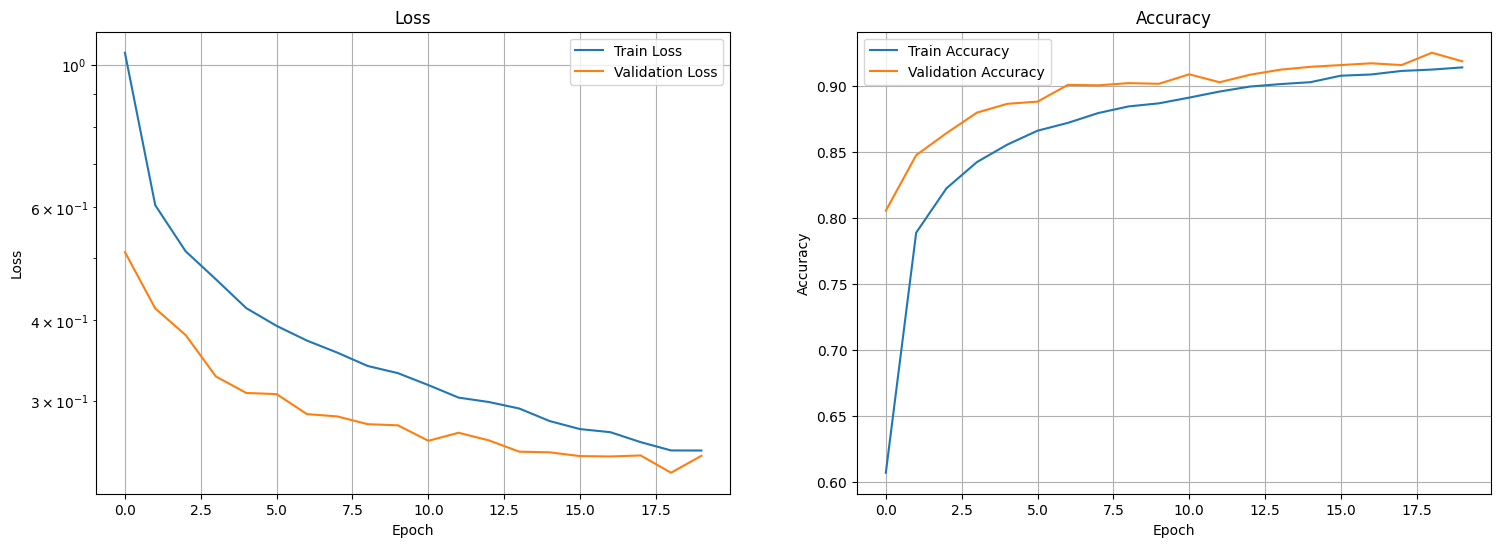

Epoch 20/20, Train Loss: 0.2510, Val Loss: 0.2463


In [66]:
for epoch in range(epochs):
    train_loss = run(model, trainloader, loss_func, optimizer)
    val_loss = run(model, valloader, loss_func)
    
    train_losses.append(train_loss[0])
    val_losses.append(val_loss[0])
    train_accuracy.append(train_loss[1])
    val_accuracy.append(val_loss[1])

    show_losses(train_losses, val_losses, train_accuracy, val_accuracy)
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss[0]:.4f}, Val Loss: {val_loss[0]:.4f}')

In [67]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 128]         401,536
              ReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 64]           8,256
             ReLU-12                   [-1, 64]               0
          Dropout-13                   [-1, 64]               0
           Linear-14                   

In [68]:
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_cm = run(model, testloader, loss_func)
val_loss, val_accuracy, val_precision, val_recall, val_f1, val_cm = run(model, valloader, loss_func)

In [69]:
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')
print('Validation Confusion Matrix:')
print(val_cm)

Validation Accuracy: 0.9193
Validation Precision: 0.9216
Validation Recall: 0.9193
Validation F1 Score: 0.9200
Validation Confusion Matrix:
[[518   0   7  17   1   0  56   0   2   0]
 [  0 587   1   9   0   1   0   0   0   0]
 [  4   0 521   3  36   2  48   0   0   0]
 [  3   6   2 537  11   0  23   0   1   0]
 [  1   0  17  12 487   0  47   0   0   0]
 [  0   0   0   0   0 626   0   9   1   3]
 [ 47   2  24   8  20   0 482   0   1   0]
 [  0   0   0   0   0   6   0 562   0  26]
 [  1   1   1   0   2   3   3   0 586   0]
 [  0   0   0   0   0   3   0  13   0 610]]


In [70]:
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print('Test Confusion Matrix:')
print(test_cm)

Test Accuracy: 0.9080
Test Precision: 0.9100
Test Recall: 0.9080
Test F1 Score: 0.9085
Test Confusion Matrix:
[[514   1   7  19   3   0  60   1   2   0]
 [  0 597   2   4   2   2   0   0   1   0]
 [  9   1 493   6  47   0  39   0   0   0]
 [  7   4   3 551  17   0  15   0   1   1]
 [  0   2  20  15 506   0  65   0   1   0]
 [  0   0   0   0   0 562   0   4   2   7]
 [ 48   1  23  17  22   0 491   0   1   0]
 [  0   0   0   0   0   9   0 598   0  30]
 [  2   0   1   2   2   2   4   0 592   0]
 [  0   0   0   0   0   3   0  14   1 544]]


### Аугментация трейнового датасета привело, в целом, к ухудшению метрик (горизонтальный разворот, изменение параметров цвета). Возможно изменения подобраны не лучшие: 

#### Модель без аугментации:

- Test Accuracy: 0.9213
- Test Precision: 0.9215
- Test Recall: 0.9213
- Test F1 Score: 0.9213


#### Модель с аугментацией:

- Test Accuracy: 0.9080
- Test Precision: 0.9100
- Test Recall: 0.9080
- Test F1 Score: 0.9085

Стоит отметить, что в итоге модель вышла лучше "ванильной" (изначальной, полносвязной) модели. Заметна разница между метриками в данных train и validate: они лучше (пересечений, ухудшений нет).